# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 473 µs (started: 2023-02-23 10:37:50 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, 
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.6 s (started: 2023-02-23 10:37:50 +00:00)


In [11]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'ResNet152V2'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'inverted' 

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/' \
            + TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print()
print('versión Keras:', keras.__version__)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_{}/splits/inverted_otsu/

versión Keras: 2.11.0
time: 1.56 ms (started: 2023-02-23 10:40:46 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 31 s (started: 2023-02-23 10:37:54 +00:00)


# Funciones

In [12]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet152V2_9G = keras.applications.ResNet152V2(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet152V2_9G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG):
    '''Guardar el modelo en disco duro.
    Debe especificarse la ruta porque por defecto la guarda
    en el la memoria de la misma instancia de Google Colab.
    
    Args:
        - WEIGHTS_PATH = Ruta en drive a la carpeta de los pesos
        - custom_model = Modelo de Deep Learning
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' \
                + TYPE_IMG +'__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)
    print(f'------ Model Saved in {WEIGHTS_PATH}')


time: 7.32 ms (started: 2023-02-23 10:40:53 +00:00)


# Imgs 64x64

- Test Accuracy: 0.422731876373291
- Test Loss: 3.5236308574676514
- time: 5h 4min 54s
- F1 score: 0.4200922122591665
- Precision score: 0.44302919700687327
- Recall:  0.4227318718381113
- Epoch: 50/50


## Cargar la imágenes

In [ ]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_64/splits/inverted_otsu/
time: 768 µs (started: 2023-02-22 10:32:56 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 9.05 s (started: 2023-02-22 10:32:56 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)


time: 1.32 ms (started: 2023-02-22 10:33:05 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 1s 0us/step
time: 8.98 s (started: 2023-02-22 10:33:05 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 382s 26ms/step - loss: 6.3875 - sparse_categorical_accuracy: 0.0796 - val_loss: 5.6812 - val_sparse_categorical_accuracy: 0.1354
Epoch 2/50
13899/13899 [==============================] - 361s 26ms/step - loss: 5.1501 - sparse_categorical_accuracy: 0.1916 - val_loss: 5.1065 - val_sparse_categorical_accuracy: 0.1914
Epoch 3/50
13899/13899 [==============================] - 360s 26ms/step - loss: 4.5842 - sparse_categorical_accuracy: 0.2537 - val_loss: 4.7697 - val_sparse_categorical_accuracy: 0.2271
Epoch 4/50
13899/13899 [==============================] - 360s 26ms/step - loss: 4.2047 - sparse_categorical_accuracy: 0.2968 - val_loss: 4.5389 - val_sparse_categorical_accuracy: 0.2525
Epoch 5/50
13899/13899 [==============================] - 361s 26ms/step - loss: 3.9201 - sparse_categorical_accuracy: 0.3320 - val_loss: 4.3668 - val_sparse_categorical_accuracy: 0.2714
Epoch 6/50
13899/13899 [==============================] - 360s 26

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.14 s (started: 2023-02-22 15:38:11 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 42s 21ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.422731876373291
- Test Loss: 3.5236308574676514
- time: 
- F1 score: 0.4200922122591665
- Precision score: 0.44302919700687327
- Recall:  0.4227318718381113
- Epoch: 
*********************************************************************************************************************************
time: 1min 25s (started: 2023-02-22 15:38:13 +00:00)


## Graficando

In [ ]:
plot_loss(history)

In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/inverted/model_resnet152v2_etl9_imgs64_inverted__OTSU.h5
time: 3.19 s (started: 2023-02-22 15:39:39 +00:00)


# Imgs 96x96

- Test Accuracy: 0.5103541612625122
- Test Loss: 3.0438709259033203
- time: 5h 23min 51s
- F1 score: 0.5100815279338201
- Precision score: 0.5314039882464512
- Recall:  0.51035413153457
- Epoch: 50/50


## Cargar las imágenes

In [ ]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

In [ ]:
print(custom_model.summary())

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 398s 28ms/step - loss: 6.3925 - sparse_categorical_accuracy: 0.0933 - val_loss: 5.6577 - val_sparse_categorical_accuracy: 0.1592
Epoch 2/50
13899/13899 [==============================] - 386s 28ms/step - loss: 5.0574 - sparse_categorical_accuracy: 0.2335 - val_loss: 5.0059 - val_sparse_categorical_accuracy: 0.2274
Epoch 3/50
13899/13899 [==============================] - 410s 29ms/step - loss: 4.4103 - sparse_categorical_accuracy: 0.3116 - val_loss: 4.6084 - val_sparse_categorical_accuracy: 0.2727
Epoch 4/50
13899/13899 [==============================] - 394s 28ms/step - loss: 3.9682 - sparse_categorical_accuracy: 0.3672 - val_loss: 4.3337 - val_sparse_categorical_accuracy: 0.3048
Epoch 5/50
13899/13899 [==============================] - 399s 29ms/step - loss: 3.6350 - sparse_categorical_accuracy: 0.4112 - val_loss: 4.1264 - val_sparse_categorical_accuracy: 0.3278
Epoch 6/50
13899/13899 [==============================] - 389s 28

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.13 s (started: 2023-02-22 21:03:56 +00:00)


## Métricas

In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 44s 22ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5103541612625122
- Test Loss: 3.0438709259033203
- time: 
- F1 score: 0.5100815279338201
- Precision score: 0.5314039882464512
- Recall:  0.51035413153457
- Epoch: 
*********************************************************************************************************************************
time: 1min 28s (started: 2023-02-22 21:18:19 +00:00)


## Graficando

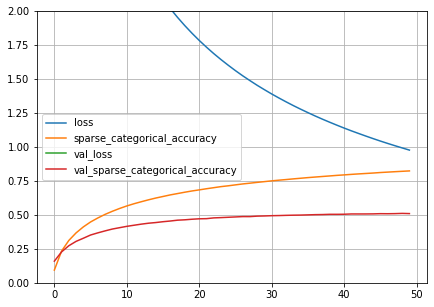

time: 203 ms (started: 2023-02-22 21:19:52 +00:00)


In [ ]:
plot_loss(history)

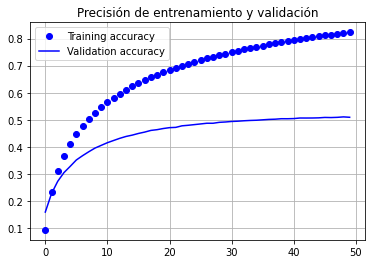

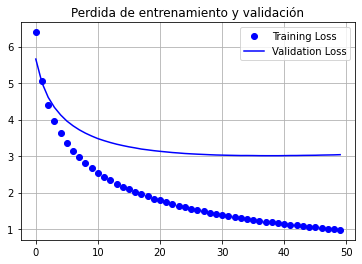

time: 1.09 s (started: 2023-02-22 21:19:55 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/inverted/model_resnet152v2_etl9_imgs96_inverted__OTSU.h5
time: 1.72 s (started: 2023-02-22 21:19:59 +00:00)


# Imgs 112x112

- Test Accuracy: 0.5683136582374573
- Test Loss: 2.5749597549438477
- time: 5h 49min 21s
- F1 score: 0.5689178363646247
- Precision score: 0.5907712868749404
- Recall:  0.5683136593591905
- Epoch: 50/50


## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 909 µs (started: 2023-02-22 21:21:07 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 20.4 s (started: 2023-02-22 21:21:07 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 1.4 ms (started: 2023-02-22 21:21:28 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.53 s (started: 2023-02-22 21:21:28 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate_2[0][0]']    

## Entrenar modelo


In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 427s 30ms/step - loss: 6.1578 - sparse_categorical_accuracy: 0.1067 - val_loss: 5.3380 - val_sparse_categorical_accuracy: 0.1840
Epoch 2/50
13899/13899 [==============================] - 413s 30ms/step - loss: 4.6997 - sparse_categorical_accuracy: 0.2651 - val_loss: 4.6061 - val_sparse_categorical_accuracy: 0.2701
Epoch 3/50
13899/13899 [==============================] - 413s 30ms/step - loss: 3.9958 - sparse_categorical_accuracy: 0.3559 - val_loss: 4.1682 - val_sparse_categorical_accuracy: 0.3242
Epoch 4/50
13899/13899 [==============================] - 414s 30ms/step - loss: 3.5224 - sparse_categorical_accuracy: 0.4203 - val_loss: 3.8618 - val_sparse_categorical_accuracy: 0.3610
Epoch 5/50
13899/13899 [==============================] - 414s 30ms/step - loss: 3.1705 - sparse_categorical_accuracy: 0.4690 - val_loss: 3.6344 - val_sparse_categorical_accuracy: 0.3894
Epoch 6/50
13899/13899 [==============================] - 415s 30

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.76 s (started: 2023-02-23 03:10:56 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 46s 23ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5683136582374573
- Test Loss: 2.5749597549438477
- time: 
- F1 score: 0.5689178363646247
- Precision score: 0.5907712868749404
- Recall:  0.5683136593591905
- Epoch: 
*********************************************************************************************************************************
time: 1min 39s (started: 2023-02-23 03:10:59 +00:00)


## Graficando

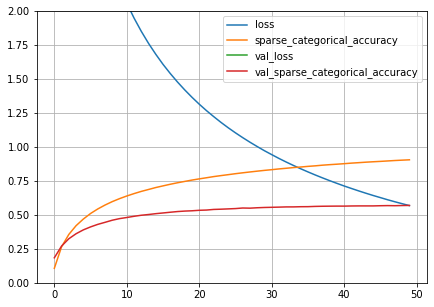

time: 199 ms (started: 2023-02-23 03:12:38 +00:00)


In [ ]:
plot_loss(history)

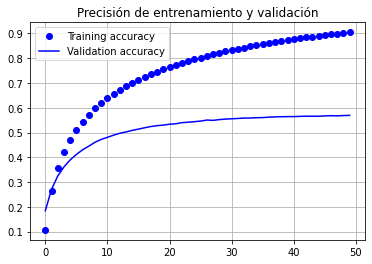

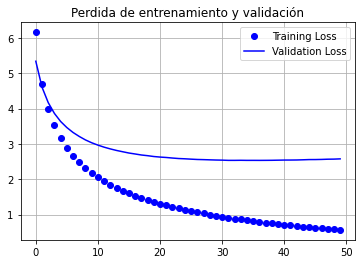

time: 402 ms (started: 2023-02-23 03:12:39 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/inverted/model_resnet152v2_etl9_imgs112_inverted__OTSU.h5
time: 1.82 s (started: 2023-02-23 03:12:39 +00:00)


# Imgs 127x127

- Test Accuracy: 0.6220910549163818
- Test Loss: 2.3309121131896973
- time: 5h 22min 54s 
- F1 score: 0.6233599839162525
- Precision score: 0.6430800123664031
- Recall:  0.6220910623946037
- Epoch: 50/50


## Cargar imágenes

In [14]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/inverted_otsu/
time: 763 µs (started: 2023-02-23 10:41:03 +00:00)


In [15]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 28.4 s (started: 2023-02-23 10:41:04 +00:00)


In [16]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 127, 127, 1) and labels: (444750,)

- val images: (88950, 127, 127, 1) and labels: (88950,)

time: 1.1 ms (started: 2023-02-23 10:41:32 +00:00)


## Preparar el modelo

In [17]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 11s 0us/step
time: 19.2 s (started: 2023-02-23 10:41:32 +00:00)


In [18]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 127, 127, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate[0][0]']        

## Entrenar modelo

In [19]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 406s 28ms/step - loss: 5.5763 - sparse_categorical_accuracy: 0.1609 - val_loss: 4.6443 - val_sparse_categorical_accuracy: 0.2584
Epoch 2/50
13899/13899 [==============================] - 389s 28ms/step - loss: 3.9716 - sparse_categorical_accuracy: 0.3541 - val_loss: 3.9125 - val_sparse_categorical_accuracy: 0.3480
Epoch 3/50
13899/13899 [==============================] - 400s 29ms/step - loss: 3.2788 - sparse_categorical_accuracy: 0.4512 - val_loss: 3.5000 - val_sparse_categorical_accuracy: 0.4020
Epoch 4/50
13899/13899 [==============================] - 386s 28ms/step - loss: 2.8317 - sparse_categorical_accuracy: 0.5166 - val_loss: 3.2268 - val_sparse_categorical_accuracy: 0.4389
Epoch 5/50
13899/13899 [==============================] - 384s 28ms/step - loss: 2.5081 - sparse_categorical_accuracy: 0.5659 - val_loss: 3.0295 - val_sparse_categorical_accuracy: 0.4669
Epoch 6/50
13899/13899 [==============================] - 383s 28

## Graficando

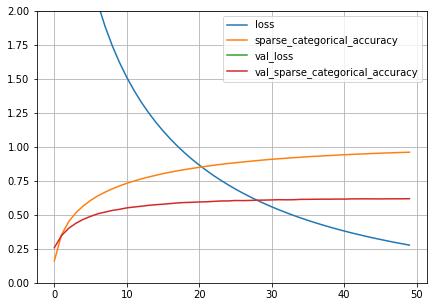

time: 400 ms (started: 2023-02-23 16:04:49 +00:00)


In [20]:
plot_loss(history)

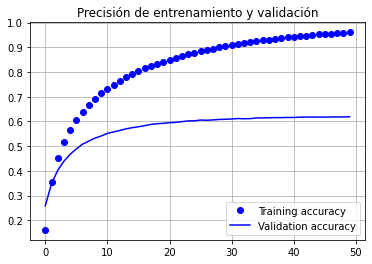

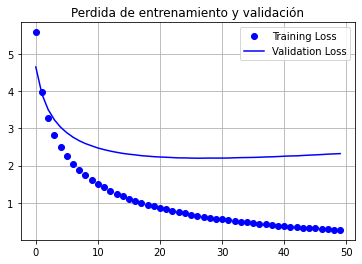

time: 391 ms (started: 2023-02-23 16:04:49 +00:00)


In [21]:
show_history(history)

In [22]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/inverted/model_resnet152v2_etl9_imgs127_inverted__OTSU.h5
time: 4.21 s (started: 2023-02-23 16:04:50 +00:00)


## Métricas

In [23]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 4.34 s (started: 2023-02-23 16:04:54 +00:00)


In [24]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 45s 23ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6220910549163818
- Test Loss: 2.3309121131896973
- time: 
- F1 score: 0.6233599839162525
- Precision score: 0.6430800123664031
- Recall:  0.6220910623946037
- Epoch: 
*********************************************************************************************************************************
time: 1min 32s (started: 2023-02-23 16:04:58 +00:00)


In [ ]:
runtime.unassign()